In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [48]:
def read_timeseries(metric, label):
    args  = {'skiprows' : 13, 'names': ["index", "Time (sec)", label]}
    fname = DIR + metric + '.wsp.out'
    try:
        df = pd.read_csv(fname, **args)
    except:
        sys.exit("Create time series (" + fname + ") does not exist, "+
                 "please cd to pipelines/hep/visualize and run ./plot.sh")    
    del df['index']
    df = df[df['Time (sec)'] != 0]
    return df

def trim(mod, axis):
    for i in range(0, len(axis)):
        if i % mod != 0:
            axis[i] = ""
    axis[0] = ""
    return axis

# annotate graph with job phases
def plot_phases(ax, metric, label, y0=1000, y1=2000, xshift=0):
    def to_seconds(timestamp):
        ts = timestamp.split(':')
        return int(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))
    
    args  = {'skiprows' : 13, 'names': ["index", "Time (sec)", label]}
    fname = DIR + metric + '.wsp.out'
    try:
        df = pd.read_csv(fname, **args)
    except:
        sys.exit("Create time series (" + fname + ") does not exist, "+
                 "please cd to pipelines/hep/visualize and run ./plot.sh")
    t = float(df.head(1)['Time (sec)'])
    print t
    ax.annotate(label, xy=(t, y0), xytext=(t+xshift, y1),
        ha='center', arrowprops=dict(facecolor='black'))
    return t
def to_seconds(timestamp):
    ts = timestamp.split(':')
    try: return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))
    except: return float(0)

def parse(expdir):
    df = pd.DataFrame(columns=['job', 'rtime', 'ts'])
    with open(expdir + '/summary.txt') as f:
        d = pd.read_csv(f, names=['job', 'delta', 'time'])
        d['rtime'] = d['delta'].apply(to_seconds)
        del d['time'], d['delta']
        d['run'] = 0
        df = df.append(d, ignore_index=True)
    return df.pivot(index='run', values='rtime', columns='job')


1518038779.0
1518038858.0


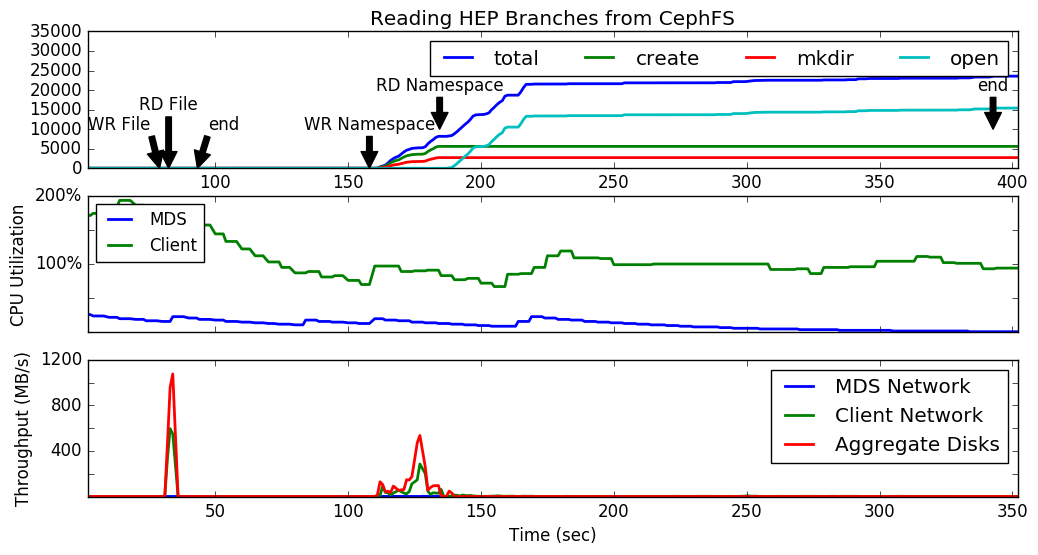

In [63]:
DIR = "../results-monitor0/"
START = 1518038452+300
END   = 1518038452+650
df = read_timeseries('handle_client_request', 'total')
for req in ['create', 'mkdir', 'open']:
    df = pd.merge(df, read_timeseries('req_'+req, req), on='Time (sec)')

fig, ax = plt.subplots(3, 1, figsize=(12, 6))
args = {'x': 'Time (sec)', 'lw': 2}
df.plot(ax=ax[0], y=['total', 'create', 'mkdir', 'open'], **args)
ax[0].set_xlim(START, END)
ax[0].set_title("Reading HEP Branches from CephFS")
ax[0].legend(loc='upper right', ncol=4)

df_util = read_timeseries('node-4-avg1', 'MDS')
df_util = pd.merge(df_util, read_timeseries('avg1', 'Client'), on='Time (sec)')
df_util.plot(ax=ax[1], y=['MDS', 'Client'], **args)
ax[1].set_xlim(START, END)
ax[1].set_ylabel("CPU Utilization")
ax[1].set_yticklabels(trim(2, ['{:3.0f}%'.format(y*100) for y in ax[1].get_yticks()]), fontsize=12)
ax[1].legend(fontsize=12, loc='upper left')
ax[1].set_xticklabels([]); ax[1].set_xlabel("")

for req in ['node-4-kbin', 'node-4-kbout',
            'node-0-kbin', 'node-0-kbout',
            'node1-sdc', 'node2-sdc', 'node3-sdc']:
    df_util = pd.merge(df_util, read_timeseries(req, req), on='Time (sec)')
df_util['Client Network'] = df_util['node-0-kbin'] + df_util['node-0-kbout']
df_util['MDS Network'] = df_util['node-4-kbin'] + df_util['node-4-kbout']
df_util['Aggregate Disks'] = df_util['node1-sdc'] + df_util['node2-sdc'] + df_util['node3-sdc']
df_util.plot(ax=ax[2], y=['MDS Network', 'Client Network', 'Aggregate Disks'], **args)
ax[2].set_ylabel("Throughput (MB/s)")
ax[2].set_xlim(START, END)
ax[2].set_yticklabels(trim(2, ['{:3.0f}'.format(y/1000) for y in ax[2].get_yticks()]), fontsize=12)
ax[2].set_xticklabels(range(0, 400, 50))

args = {'ha'   : 'center', 'arrowprops': dict(facecolor='black')}
runtimes = parse(DIR)
start = plot_phases(ax[0], 'cephfs', 'WR File', y0=0, y1=10000, xshift=-15)
end   = start + runtimes['write_cephfs']
ax[0].annotate('RD File', xy=(end, 0), xytext=(end, 15000), **args)
end   = end + runtimes['read_cephfs']
ax[0].annotate('end', xy=(end, 0), xytext=(end+10, 10000), **args)

start = plot_phases(ax[0], 'fpb_cephfs', 'WR Namespace', y0=0, y1=10000)
end   = start + runtimes['write_fpb_cephfs']
ax[0].annotate('RD Namespace', xy=(end, 10000), xytext=(end, 20000), **args)
end   = end + runtimes['read_fpb_cephfs']
ax[0].annotate('end', xy=(end, 10000), xytext=(end, 20000), **args)


In [34]:
DIR = "../results-monitor0/"
START = 1517964152-100
END   = 1517964152+300
df = read_timeseries('req_create', 'create')
for req in ['mkdir', 'open']:
    df = pd.merge(df, read_timeseries('req_'+req, req), on='Time (sec)')
df = pd.merge(df, read_timeseries('handle_client_request', 'req'), on='Time (sec)')    
#df = df[df['create'] > 1] # lop off the beginning of the trace
print df.head()

# plot the graph
font = {'size'   : 12}; matplotlib.rc('font', **font)
fig, ax = plt.subplots(3, 1, figsize=(12, 6))
args = {'x': 'Time (sec)', 'lw': 2}

df.plot(ax=ax[0], y=['create', 'mkdir', 'open', 'req'], **args)
ax[0].set_ylabel("# of Operations")
ax[0].set_yticklabels(['{:3.0f}K'.format(y/1000) for y in ax[0].get_yticks()])
ax[0].set_xlim(START, END)
ax[0].set_title("Reading HEP Branches from CephFS") 
ax[0].legend(fontsize=12, loc='upper right', ncol=4)
ax[0].set_xticklabels([]); ax[0].set_xlabel("")
ax[0].set_ylim(0, 40000)

# parse into data frames
df_util = read_timeseries('avg1', 'CPU')
for req in ['kbin', 'kbout', 'node1-sdc', 'node2-sdc', 'node3-sdc']:
    df_util = pd.merge(df_util, read_timeseries(req, req), on='Time (sec)')
#df_util['Client Network'] = df_util['kbin'] + df_util['kbout']
df_util['MDS Network'] = df_util['kbin'] + df_util['kbout']
df_util['Aggregate Disks'] = df_util['node1-sdc'] + df_util['node2-sdc'] + df_util['node3-sdc']

df_util.plot(ax=ax[1], y=['CPU'], **args)
ax[1].set_ylabel("Utilization")
ax[1].set_yticklabels(trim(2, ['{:3.0f}%'.format(y*100) for y in ax[1].get_yticks()]), fontsize=12)
ax[1].set_xlim(START, END)
ax[1].legend(fontsize=12, loc='upper left')
ax[1].set_xticklabels([]); ax[1].set_xlabel("")

df_util.plot(ax=ax[2], y=['Aggregate Disks', 'MDS Network'], **args)
ax[2].set_ylabel("Throughput (MB/s)")
ax[2].set_xlim(START, END)
ax[2].set_yticklabels(trim(2, ['{:3.0f}'.format(y/1000) for y in ax[2].get_yticks()]), fontsize=12)

# plot some arrows
args = {'ha'   : 'center', 'arrowprops': dict(facecolor='black')}
runtimes = parse(DIR)
start = plot_phases(ax[0], 'cephfs', 'WR File', y0=0, y1=15000)
end   = start + runtimes['write_cephfs']
ax[0].annotate('RD File', xy=(end, 0), xytext=(end+15, 10000), **args)
start = plot_phases(ax[0], 'fpb_cephfs', 'WR Namespace', y0=0, y1=10000)
end   = start + runtimes['write_fpb_cephfs']
ax[0].annotate('RD Namespace', xy=(end, 10000), xytext=(end, 20000), **args)
end   = end + runtimes['read_fpb_cephfs']
ax[0].annotate('end', xy=(end, 10000), xytext=(end, 20000), **args)

#fig.savefig('../../../paper/figures/compile-ops.png', bbox_inches='tight', dpi=400)

SystemExit: Create time series (../results-monitor0/req_create.wsp.out) does not exist, please cd to pipelines/hep/visualize and run ./plot.sh

To exit: use 'exit', 'quit', or Ctrl-D.


   Time (sec)  create  mkdir  open  req
0  1517963773       0      0     0    1
1  1517963774       0      0     0    1
2  1517963775       0      0     0    1
3  1517963776       0      0     0    1
4  1517963777       0      0     0    1
1517964072.0
1517964149.0


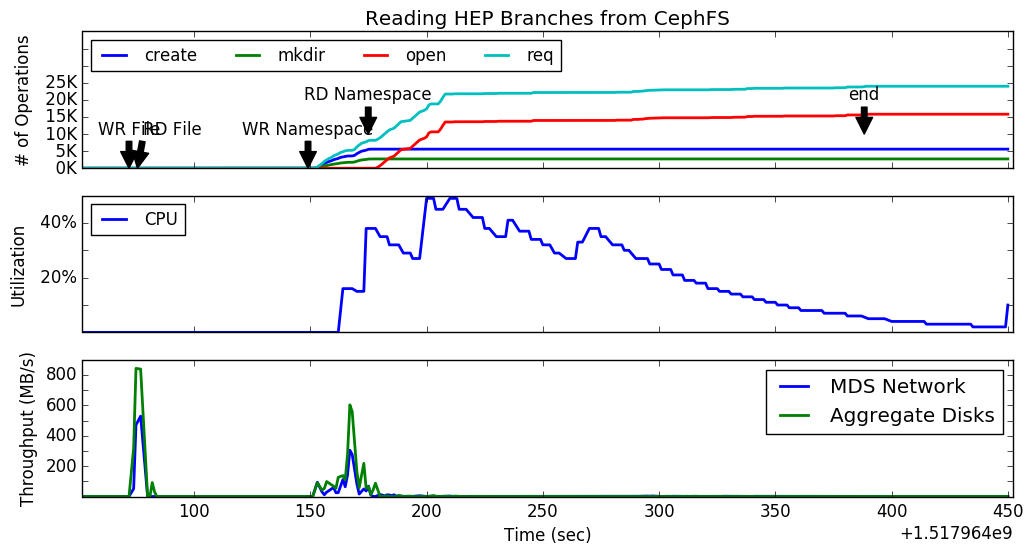

In [32]:
DIR = "../results-monitor/"
START = 1517964152-100
END   = 1517964152+300
df = read_timeseries('req_create', 'create')
for req in ['mkdir', 'open']:
    df = pd.merge(df, read_timeseries('req_'+req, req), on='Time (sec)')
df = pd.merge(df, read_timeseries('handle_client_request', 'req'), on='Time (sec)')    
#df = df[df['create'] > 1] # lop off the beginning of the trace
print df.head()

# plot the graph
font = {'size'   : 12}; matplotlib.rc('font', **font)
fig, ax = plt.subplots(3, 1, figsize=(12, 6))
args = {'x': 'Time (sec)', 'lw': 2}

df.plot(ax=ax[0], y=['create', 'mkdir', 'open', 'req'], **args)
ax[0].set_ylabel("# of Operations")
ax[0].set_yticklabels(['{:3.0f}K'.format(y/1000) for y in ax[0].get_yticks()])
ax[0].set_xlim(START, END)
ax[0].set_title("Reading HEP Branches from CephFS") 
ax[0].legend(fontsize=12, loc='upper left', ncol=4)
ax[0].set_xticklabels([]); ax[0].set_xlabel("")
ax[0].set_ylim(0, 40000)

# parse into data frames
df_util = read_timeseries('avg1', 'CPU')
for req in ['kbin', 'kbout', 'node1-sdc', 'node2-sdc', 'node3-sdc']:
    df_util = pd.merge(df_util, read_timeseries(req, req), on='Time (sec)')
#df_util['Client Network'] = df_util['kbin'] + df_util['kbout']
df_util['MDS Network'] = df_util['kbin'] + df_util['kbout']
df_util['Aggregate Disks'] = df_util['node1-sdc'] + df_util['node2-sdc'] + df_util['node3-sdc']

df_util.plot(ax=ax[1], y=['CPU'], **args)x
ax[1].set_ylabel("Utilization")
ax[1].set_yticklabels(trim(2, ['{:3.0f}%'.format(y*100) for y in ax[1].get_yticks()]), fontsize=12)
ax[1].set_xlim(START, END)
ax[1].legend(fontsize=12, loc='upper left')
ax[1].set_xticklabels([]); ax[1].set_xlabel("")

df_util.plot(ax=ax[2], y=['MDS Network', 'Aggregate Disks'], **args)
ax[2].set_ylabel("Throughput (MB/s)")
ax[2].set_xlim(START, END)
ax[2].set_yticklabels(trim(2, ['{:3.0f}'.format(y/1000) for y in ax[2].get_yticks()]), fontsize=12)

# plot some arrows
args = {'ha'   : 'center', 'arrowprops': dict(facecolor='black')}
runtimes = parse(DIR)
start = plot_phases(ax[0], 'cephfs', 'WR File', y0=0, y1=10000)
end   = start + runtimes['write_cephfs']
ax[0].annotate('RD File', xy=(end, 0), xytext=(end+15, 10000), **args)
start = plot_phases(ax[0], 'fpb_cephfs', 'WR Namespace', y0=0, y1=10000)
end   = start + runtimes['write_fpb_cephfs']
ax[0].annotate('RD Namespace', xy=(end, 10000), xytext=(end, 20000), **args)
end   = end + runtimes['read_fpb_cephfs']
ax[0].annotate('end', xy=(end, 10000), xytext=(end, 20000), **args)

#fig.savefig('../../../paper/figures/compile-ops.png', bbox_inches='tight', dpi=400)